# SIGCSE presentation charts

In [20]:
import math
import matplotlib.pyplot as plt
import random
import numpy as np

# Given a number of minutes x since the last keystroke,
# returns the probability that the student was on task.
# Uses the model from Hart et al, ITiCSE 2022.
def p(x):
    if x < .75:
        m = -(1-0.8072438106027864)/.75
        return m*x+1
    Q = 6604
    B = -4.99
    M = 0.01
    v = 58.32
    return 1 / (1+Q*math.e**(-B*(x-M)))**(1/v)

# Given a number of minutes x since the last keystroke,
# returns whether the student was on task. Uses p(x)
# to get the probability then rolls the dice to see if
# we count the student as being on task or not.
def on_task(x):
    if x <= 0:
        return False
    if x > 60:
        return False
    return random.random() < p(x)

# # Example: about half of the time the student will be on task
# # after 3 minutes
# for i in range(10):
#     print(on_task(3))

# X = [m for m in np.arange(0,60,.1)]
# y = [p(x) for x in X]
# plt.plot(X, y)

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
df_orig = pd.read_csv('keystrokes.csv')

In [4]:
df = df_orig.copy()
df = df[df.EventType == 'File.Edit']
df['elapsed'] = df.ClientTimestamp - df.shift(1).ClientTimestamp
df['ID'] = df.SubjectID + df.AssignmentID + df.CodeStateSection
df.loc[df.ID != df.shift(1).ID, 'elapsed'] = 0

In [5]:
f = 60*1000
mp = {'A':1*f, 'B':3*f, 'C':30*f, 'D':60*f}
for a,b in mp.items():
    print(a, b)

A 60000
B 180000
C 1800000
D 3600000


In [6]:
test = df.groupby(['SubjectID', 'AssignmentID']).agg({'elapsed':'sum'}).reset_index()
test.elapsed = test.elapsed/(1000*60*60)
for a,b in mp.items():
    test2 = df.copy()
    test2 = test2[test2.elapsed < b]
    test2 = test2.groupby(['SubjectID', 'AssignmentID']).agg({'elapsed':'sum'}).reset_index()
    test2.elapsed = test2.elapsed/(1000*60*60)
    test[a] = test2.elapsed

test2 = df.copy()
test2 = test2[(test2.elapsed/(60*1000)).apply(on_task)]
test2 = test2.groupby(['SubjectID', 'AssignmentID']).agg({'elapsed':'sum'}).reset_index()
test2.elapsed = test2.elapsed/(1000*60*60)
test['Ours'] = test2.elapsed
    
    
# df.groupby(['SubjectID', 'AssignmentID']).agg({'elapsed':'sum'}).reset_index()
test = test.reset_index()
test = test[['SubjectID', 'AssignmentID', 'elapsed', 'A', 'B', 'C', 'D', 'Ours']]
test.columns = ['SubjectID', 'AssignmentID', 'X', '< 1', '< 3', '< 30', '< 60', 'Model']

In [7]:
test.head()

,SubjectID,AssignmentID,X,< 1,< 3,< 30,< 60,Model
0,Student1,Assign10,0.029404,0.029404,0.029404,0.029404,0.029404,0.028725
1,Student1,Assign12,1.211849,0.439374,0.721544,1.211849,1.211849,0.781156
2,Student1,Assign13,6.241282,0.515024,0.877867,1.994802,1.994802,1.432595
3,Student1,Assign6,34.466337,1.173921,1.688196,3.671382,4.466881,2.232183
4,Student1,Assign7,47.178476,0.778018,1.229093,2.319680,2.984629,1.326901


In [8]:
test = test.set_index(['SubjectID','AssignmentID']).stack().reset_index()
test.columns = ['SubjectID', 'AssignmentID', 'test', 'elapsed']
test.head()

,SubjectID,AssignmentID,test,elapsed
0,Student1,Assign10,X,0.029404
1,Student1,Assign10,< 1,0.029404
2,Student1,Assign10,< 3,0.029404
3,Student1,Assign10,< 30,0.029404
4,Student1,Assign10,< 60,0.029404


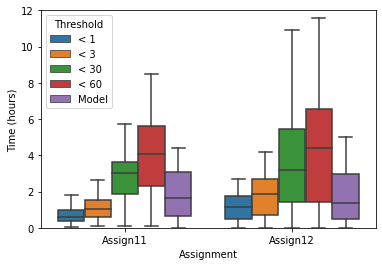

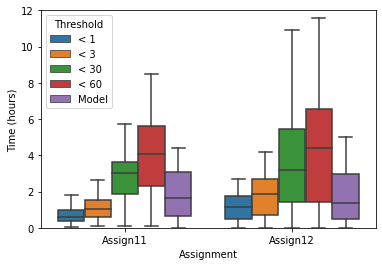

In [18]:
toplot = test
toplot = toplot[test.test != 'X']

sns.boxplot(hue = 'test', x="AssignmentID", y="elapsed", data=toplot, order=['Assign11', 'Assign12'])
plt.ylim([0,12])
plt.ylabel('Time (hours)')
plt.xlabel('Assignment')
plt.legend(title='Threshold')
plt.savefig('compare.pdf', bbox_inches='tight')

plt.figure()
sns.boxplot(hue = 'test', x="AssignmentID", y="elapsed", data=toplot, order=['Assign11', 'Assign12'])
plt.ylim([0,12])
plt.ylabel('Time (hours)')
plt.xlabel('Assignment')
plt.legend(title='Threshold')
plt.savefig('compare.pdf', bbox_inches='tight')

In [19]:
test.groupby(['AssignmentID', 'test']).median()

elapsed
AssignmentID test             
Assign10     < 1      0.033561
             < 3      0.073137
             < 30     0.355360
             < 60     0.661949
             Model    1.384855
             X       24.615897
Assign11     < 1      0.597581
             < 3      1.010097
             < 30     3.051294
             < 60     4.057523
             Model    1.647467
             X       43.104867
Assign12     < 1      1.172499
             < 3      1.865046
             < 30     3.167792
             < 60     4.381275
             Model    1.381536
             X       47.581947
Assign13     < 1      0.337609
             < 3      0.544281
             < 30     0.965614
             < 60     1.671109
             Model    3.488379
             X      108.911594
Assign6      < 1      1.855297
             < 3      2.746749
             < 30     4.478458
             < 60     5.270868
             Model    2.768194
             X       72.588427
Assign7      < 1      1.791550
             < 3      2.599864
             < 30     5.199969
             < 60     5.901218
             Model    2.370741
             X       65.161257
Assign8      < 1      1.115235
             < 3      1.857733
             < 30     3.674933
             < 60     4.508832
             Model    2.214535
             X       57.526988
Assign9      < 1      1.276538
             < 3      1.857057
             < 30     4.725758
             < 60     6.371405
             Model    0.979016
             X       81.420477

In [96]:
test.columns

Index(['index', 'SubjectID', 'AssignmentID', 'elapsed', 'A', 'B', 'C', 'D'], dtype='object')

In [98]:
display(test.head())
# test.melt(id_vars=['index', 'SubjectID', 'AssignmentID'], 
#           var_name='test', 
#           value_name='A')


,SubjectID,AssignmentID,X,A,B,C,D
0,Student1,Assign10,0.029404,0.029404,0.029404,0.029404,0.029404
1,Student1,Assign12,1.211849,0.439374,0.721544,1.211849,1.211849
2,Student1,Assign13,6.241282,0.515024,0.877867,1.994802,1.994802
3,Student1,Assign6,34.466337,1.173921,1.688196,3.671382,4.466881
4,Student1,Assign7,47.178476,0.778018,1.229093,2.319680,2.984629


,SubjectID,AssignmentID,level_2,0
0,Student1,Assign10,X,0.029404
1,Student1,Assign10,A,0.029404
2,Student1,Assign10,B,0.029404
3,Student1,Assign10,C,0.029404
4,Student1,Assign10,D,0.029404
...,...,...,...,...
1300,Student9,Assign9,X,145.293376
1301,Student9,Assign9,A,4.770254
1302,Student9,Assign9,B,6.937944
1303,Student9,Assign9,C,10.995313


In [23]:
df = df_orig


In [28]:
df[['SubjectID','AssignmentID']].head()
display(df.iloc[:,[2,4]].head())
display(df.head())

,AssignmentID,EventType
0,Assign10,File.Edit
1,Assign10,File.Edit
2,Assign10,X-Action
3,Assign10,File.Edit
4,Assign10,X-Action


,EventID,SubjectID,AssignmentID,CodeStateSection,EventType,SourceLocation,EditType,InsertText,DeleteText,X-Metadata,ClientTimestamp,ToolInstances,CodeStateID
0,0,Student1,Assign10,task1.py,File.Edit,0.0,Insert,# @@@@@@@@@@@@@\n# CS1400 - MW1\n# Assignment ??,NaN,NaN,1636696834375,PC;PP 1.1.10,NaN
1,1,Student1,Assign10,task1.py,File.Edit,46.0,Insert,\n,NaN,NaN,1636696835921,PC;PP 1.1.10,NaN
2,2,Student1,Assign10,task1.py,X-Action,NaN,NaN,NaN,NaN,Enter,1636696838793,PC;PP 1.1.10,NaN
3,3,Student1,Assign10,task1.py,File.Edit,47.0,Insert,\n,NaN,NaN,1636696839138,PC;PP 1.1.10,NaN
4,4,Student1,Assign10,task1.py,X-Action,NaN,NaN,NaN,NaN,Paste,1636696840014,PC;PP 1.1.10,NaN
